In [1]:
import numpy as np
import ot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import W2_dist, BaseTransport, GaussianTransport, get_trajectories_for_plotting, \
                  calc_parsimony, get_desiderata

# We will be using data from  the UCI: Gas sensor array under dynamic gas mixtures Data Set
# Link: https://archive.ics.uci.edu/ml/datasets/gas+sensor+array+under+dynamic+gas+mixtures
data_dir = Path('data')

In [2]:
# Experiment hyperparamters
rng = np.random.RandomState(42)
split_on_income = False  # if True, split on income, if False, split on sex

In [3]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [4]:
!dir $data_dir

adult.data   breast-cancer-wisconsin.data   civilcomments_v1.0
adult.names  breast-cancer-wisconsin.names  wdbc.data


## Loading and Preprocessing the data
Since our data inclues continuous, categorical, and binary data, and for OT we need everything to be in a continous space (at least for now), so we do the following:
* we first encode our categorical variabels to a one-hot vector (e.g., martial status goes from being a variable with 7 options to 7 binary variables))
* any ordinal variables are interger encoded (e.g. education(HS-grad) < education(Bachelors) < education(Masters))
* finally all variables are normalized to 0 mean and unit variance.

Note: For eduation, Assoc-acdm and Assoc-voc are equally ranked as well as Doctorate and Prof-school. The ranking is as follows: 
`Preschool, 1st-4th, 5th-6th, 7th-8th, 9th, 10th, 11th, 12th, HS-grad, Some-college, [Assoc-acdm, Assoc-voc], Bachelors, Masters, [Prof-school, Doctorate]`

**However**, for merely calculating distances, we do not need to be in a continuous space. So for both categorical and binary variables, we claim $d(x, y)^2 = \{2, \text{if } x \neq y; ~ 0 \text{ if } x = y\}$ since this is the expected squared distance between two samples from a standard normal distribution, and for continuous variables we use the standard squared euclidean cost.

In [5]:
from data_utils import load_and_preprocess_adult_income_dataset
continuous_variables_indicies = [0, 1]
# n_samples = 'balanced'
n_samples = 1000
X, Y, feature_names = load_and_preprocess_adult_income_dataset(
            data_dir, split_on_income, rng, n_samples, return_column_names=True)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()

Finished preprocessing adult income dataset.  Split on sex with resulting source shape: (1000, 3), target shape: (1000, 3).


## Performing Clustering

In [6]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [7]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [8]:
## Hyperparameters
max_clusters = 10

In [9]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, 
                                                       Z=Z_continuous,
                                                       n_clusters=n_clusters,
                                                       rng=rng) 
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 1.070, Par: 0.000, Inter: 0
Fid: 0.249, Par: 1683.024, Inter: 1
Fid: 0.195, Par: 1397.605, Inter: 2
Fid: 0.120, Par: 1109.194, Inter: 3
Fid: 0.111, Par: 1028.832, Inter: 4
Fid: 0.092, Par: 1026.224, Inter: 5
Fid: 0.080, Par: 1035.004, Inter: 6
Fid: 0.087, Par: 1031.336, Inter: 7
Fid: 0.098, Par: 1025.896, Inter: 8
Fid: 0.083, Par: 1050.314, Inter: 9
Fid: 0.091, Par: 1040.050, Inter: 10


In [10]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on sex:


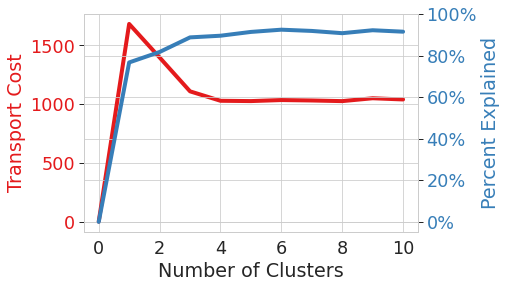

In [11]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)


if split_on_income:
    dropped_feature = 'income'
else:
    dropped_feature = 'sex'

print(f'Results with splitting on {dropped_feature}:')
if save_figures: plt.savefig(
    figure_dir / f'adult-income-split-on-{dropped_feature}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

In [12]:
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    print(f'Starting {n_clusters} cluster results:')


    if split_on_income:
        tgt = 'under50k'
        src = 'over 50k'
    else:
        tgt = 'female'
        src = ' male '
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t         Names={[name[:3] for name in feature_names]}')
            print(f'\t\t   {src}_mean={X[cluster_idx==labels].mean(axis=0)}')
            print(f'\t\tT({tgt})_mean={Z_clusters[cluster_idx==labels].mean(axis=0)}')
        print()    

Starting 1 cluster results:
	Cluster: 0
		         Names=['age', 'edu', 'inc']
		    male _mean=[39.861 10.099  0.291]
		T(female)_mean=[36.632 10.086  0.101]

Starting 2 cluster results:
	Cluster: 0
		         Names=['age', 'edu', 'inc']
		    male _mean=[31.248  9.406  0.041]
		T(female)_mean=[27.837  9.398  0.006]
	Cluster: 1
		         Names=['age', 'edu', 'inc']
		    male _mean=[49.972 10.913  0.585]
		T(female)_mean=[46.957 10.893  0.213]

Starting 3 cluster results:
	Cluster: 0
		         Names=['age', 'edu', 'inc']
		    male _mean=[29.655  9.727  0.021]
		T(female)_mean=[26.204  9.651  0.002]
	Cluster: 1
		         Names=['age', 'edu', 'inc']
		    male _mean=[43.965 12.208  0.898]
		T(female)_mean=[40.673 12.028  0.345]
	Cluster: 2
		         Names=['age', 'edu', 'inc']
		    male _mean=[55.246  8.342  0.108]
		T(female)_mean=[52.533  8.65   0.008]

Starting 4 cluster results:
	Cluster: 0
		         Names=['age', 'edu', 'inc']
		    male _mean=[35.574 12.926  0.   ]
		T(fema

In [13]:
# ergonomic blank space : ) 






























































